<a href="https://colab.research.google.com/github/AdityaJoshi17/Major/blob/main/ucm_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'landuse-scene-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F915557%2F1552478%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240316%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240316T061241Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D814395c5e4afb45adebb7ba2a83603f31ac2657ad7395d07138d9c3b1b40d02b710e45f944749d1b23003a10d337c6733620fb8452e746625eebb396273b1f60496f0f8efb818ac72034db343f374bf773147234bcb5c60948f2717c1d47e1d78964f37922a835e58147860dab0baa9a58e720c49930c29c2c9f1ebc3350b4342420349383ba7b294c801d3d4cd843b50606f280280e1f6ec56e4ce59712d5ba4f38da3d668907d45bcaf3aff099576fa2c925391f836f745235254492b5480328c56aef5f3ab52b3d2791f23b51fa59e2e9a526d20561e95342e94305e96ec94e33c4e0d8df730fca4c967438f40ea5e2fe6335fbf2c687cb8908457c424b5e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2129993655 bytes downloaded
Downloaded and uncompressed: landuse-scene-classification
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
train_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/train"
test_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/test"
val_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/validation"

In [4]:
#processing the data
import tensorflow as tf
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
val_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [5]:
#creating datasets
train_data = train_gen.flow_from_directory(train_dir,target_size=(224,224),class_mode="categorical",batch_size=32)
test_data= test_gen.flow_from_directory(test_dir,target_size=(224,224),class_mode="categorical",batch_size=32)
val_data = val_gen.flow_from_directory(val_dir,target_size=(224,224),class_mode="categorical",batch_size=32)

Found 7350 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [6]:
image, label= train_data.next()
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 21)


In [7]:
class_label=list(train_data.class_indices.keys())

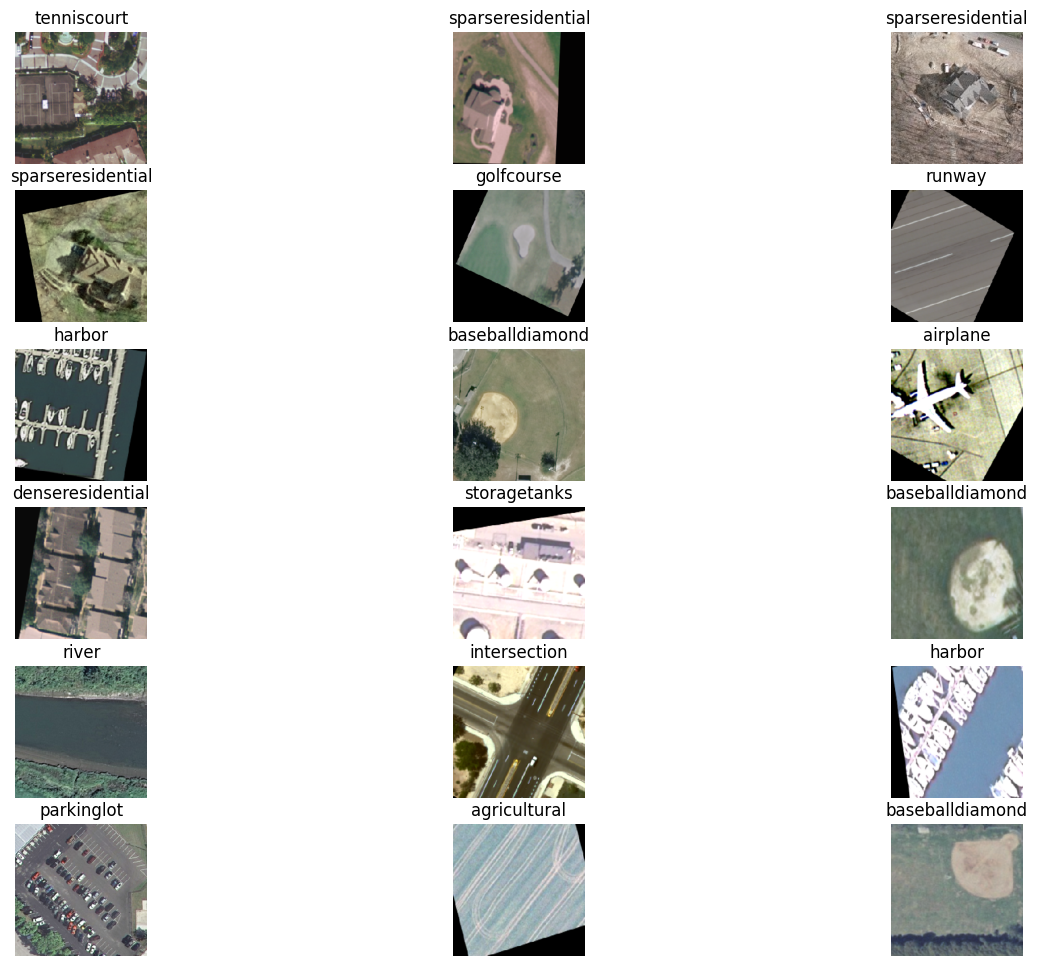

In [8]:
#visualizing the train dataset

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,12))

image,label = train_data.next()
for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i])
    plt.title(class_label[tf.argmax(label[i])])
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
def create_model():
    model=Sequential()
    model.add(Conv2D(64,(3,3),activation='relu',input_shape=(224,224,3)))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(256,(3,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(512,(3,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(21,activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=["accuracy"])
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
    return model

In [ ]:
#create model
remote_sensed=create_model()
#display model architecture
remote_sensed.summary()

In [ ]:
ret_model = remote_sensed.fit(train_data, epochs=12, validation_data=val_data)

In [ ]:
history_dict = ret_model.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
loss = ret_model.history['loss']
val_loss = ret_model.history['val_loss']
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Transfer Learning using EfficientNetB7

In [9]:
# processing the data for efficientnet


train_eff = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode = "categorical",image_size = (224,224),batch_size = 32)

test_eff = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode = "categorical",image_size = (224,224),batch_size = 32)
val_eff = tf.keras.preprocessing.image_dataset_from_directory(val_dir,label_mode = "categorical",image_size = (224,224),batch_size = 32)

Found 7350 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.


In [10]:
# building model for efficientnet7
import tensorflow as tf

eff_base = tf.keras.applications.EfficientNetB7(include_top= False)

eff_base.trainable = False

258076736/258076736 [==============================] - 1s 0us/step


In [11]:

from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224,224,3))

x = eff_base(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(21, activation="softmax")(x)

eff_model = tf.keras.Model(inputs, outputs)

In [12]:
# compiling the model

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [13]:
# fitting data to the model

ret_model=eff_model.fit( train_eff,
             epochs = 5,
             steps_per_epoch = len(train_eff),
             validation_data = val_eff,
             validation_steps = len(val_eff)
             )

Epoch 1/5
230/230 [==============================] - 146s 519ms/step - loss: 0.8206 - accuracy: 0.8136 - val_loss: 0.3548 - val_accuracy: 0.9133
Epoch 2/5
230/230 [==============================] - 109s 472ms/step - loss: 0.2816 - accuracy: 0.9318 - val_loss: 0.2394 - val_accuracy: 0.9419
Epoch 3/5
230/230 [==============================] - 109s 474ms/step - loss: 0.1953 - accuracy: 0.9533 - val_loss: 0.1912 - val_accuracy: 0.9538
Epoch 4/5
230/230 [==============================] - 109s 473ms/step - loss: 0.1512 - accuracy: 0.9664 - val_loss: 0.1633 - val_accuracy: 0.9610
Epoch 5/5
230/230 [==============================] - 110s 475ms/step - loss: 0.1252 - accuracy: 0.9733 - val_loss: 0.1472 - val_accuracy: 0.9619


<ipython-input-14-299fd5fa2580>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')


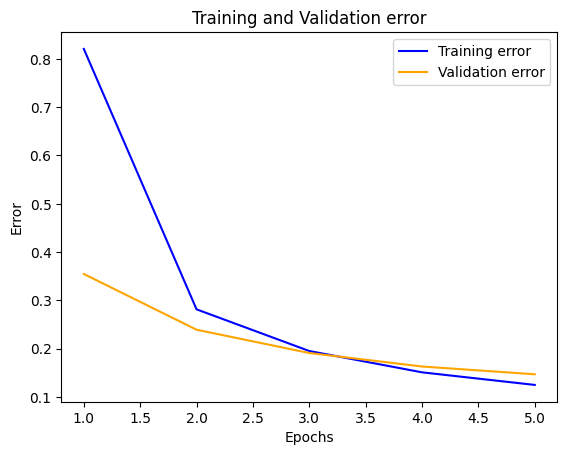

In [14]:
history_dict = ret_model.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

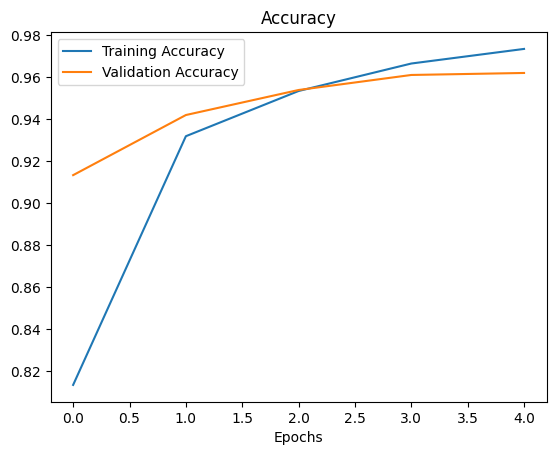

In [15]:
loss = ret_model.history['loss']
val_loss = ret_model.history['val_loss']
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Fine tuning the model

In [16]:
# Fine tunning the model

eff_base.trainable = True

for layer in eff_base.layers[:-3]:
    eff_base.trainable = False

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

ret_model=eff_model.fit(train_eff,
              epochs = 5,
              steps_per_epoch = len(train_eff),
              validation_data = val_eff,
              validation_steps = len(val_eff))

Epoch 1/5
230/230 [==============================] - 158s 586ms/step - loss: 0.1067 - accuracy: 0.9752 - val_loss: 0.1225 - val_accuracy: 0.9643
Epoch 2/5
230/230 [==============================] - 110s 475ms/step - loss: 0.0828 - accuracy: 0.9837 - val_loss: 0.1128 - val_accuracy: 0.9643
Epoch 3/5
230/230 [==============================] - 109s 473ms/step - loss: 0.0707 - accuracy: 0.9854 - val_loss: 0.1039 - val_accuracy: 0.9667
Epoch 4/5
230/230 [==============================] - 110s 476ms/step - loss: 0.0563 - accuracy: 0.9898 - val_loss: 0.0981 - val_accuracy: 0.9710
Epoch 5/5
230/230 [==============================] - 110s 475ms/step - loss: 0.0536 - accuracy: 0.9891 - val_loss: 0.0922 - val_accuracy: 0.9719


<ipython-input-17-299fd5fa2580>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')


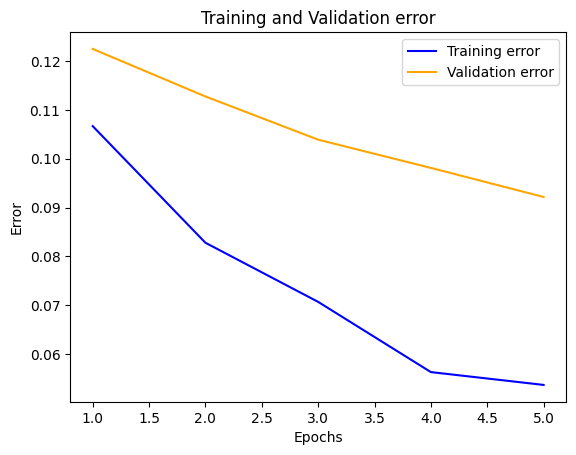

In [17]:
history_dict = ret_model.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

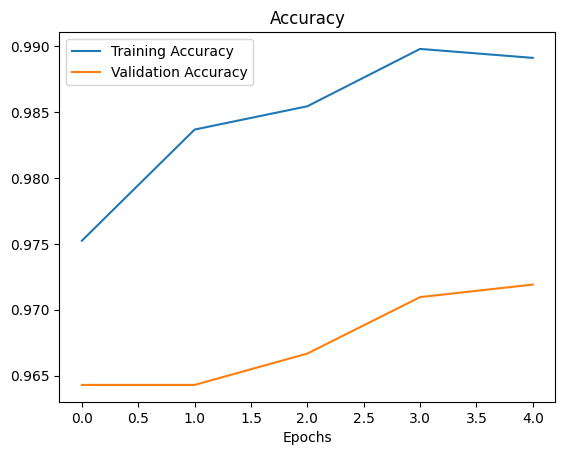

In [18]:
loss = ret_model.history['loss']
val_loss = ret_model.history['val_loss']
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [19]:
print(f"Efficient Accuracy {eff_model.evaluate(val_eff)[1] * 100 : 0.2f} %")

66/66 [==============================] - 25s 369ms/step - loss: 0.0922 - accuracy: 0.9719
Efficient Accuracy  97.19 %


In [20]:
labels_name = test_eff.class_names
len(labels_name)

21

1/1 [==============================] - 6s 6s/step


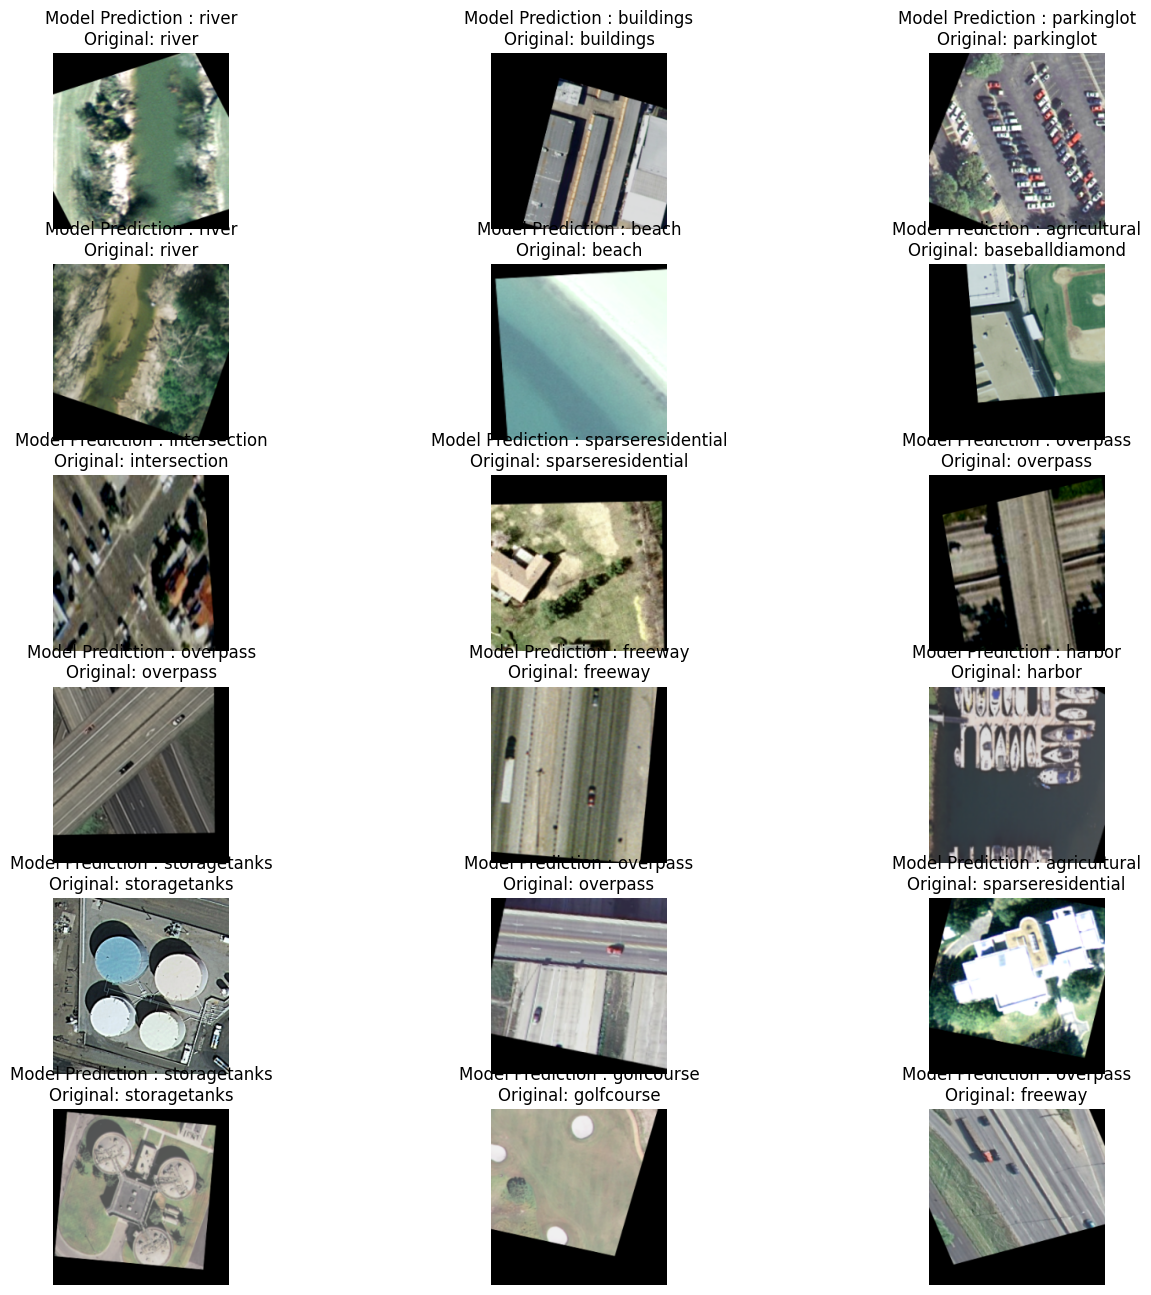

In [21]:
# predicting and visualizing the images

import tensorflow as tf
import matplotlib.pyplot as plt

plt.figure(figsize = (16,16))

for image,label in test_eff.take(1):
    model_prediction = eff_model.predict(image)

for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction : {labels_name[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal: {labels_name[tf.argmax(label[i])]}")
    plt.axis("off")

# **SAVING MODEL**

In [22]:
import h5py

In [23]:
h5_file = h5py.File('my_model.h5', 'a')
h5_file_path='my_model.h5'

In [24]:
eff_model.save_weights('my_model_final.h5')

**GUI**